In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from scipy.stats import norm, probplot
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

###### Part 0: Data Preparation

In [2]:
# ------------------------------
# Load and Transform Data
# ------------------------------
# Load data
df_original = pd.read_csv('final_data.csv', index_col=0)
df = df_original.drop(['Portfolio', 'CPI', 'T10Y2Y'], axis=1)
df = df.loc[:, ~df.columns.str.contains(r'^Port_.*_Rtn$')]

In [3]:
# ------------------------------
# Check and Handle Stationarity
# ------------------------------
def adf_test(series, max_diff=1):
    """Perform the Augmented Dickey-Fuller test with automatic differencing."""
    original_series = series.copy()
    results = {}
    
    for i in range(max_diff + 1):
        result = adfuller(original_series.dropna())
        p_value = result[1]
        is_stationary = p_value < 0.05
        
        results[f'Diff_{i}'] = {
            'ADF Statistic': result[0],
            'p-value': p_value,
            'Critical Values': result[4],
            'is_stationary': is_stationary
        }
        
        if is_stationary:
            break  # Stop if the series is stationary
        
        original_series = original_series.diff().dropna()  # Apply differencing
    
    # Final result after differencing
    final_result = results[f'Diff_{min(i, max_diff)}']
    final_result['diff_order'] = min(i, max_diff)
    return original_series, pd.Series(final_result)


# Apply ADF test to each column in the DataFrame
transformed_columns = {}
stationarity_results = {}

for col in df.columns:
    transformed_series, adf_result = adf_test(df[col])
    transformed_columns[col] = transformed_series
    stationarity_results[col] = adf_result

# Create transformed DataFrame
stationary_df = pd.DataFrame(transformed_columns)
stationary_df.dropna(inplace=True)

# Summarize ADF results
adf_results_df = pd.DataFrame(stationarity_results).T

# Drop non-stationary columns
drop_columns = adf_results_df[~adf_results_df['is_stationary']].index
stationary_df = stationary_df.drop(columns=drop_columns)

##### Part 1: Modeling

In [4]:
# ------------------------------
# Split Data
# ------------------------------
# Split for modeling and backtesting
model_df = stationary_df[:'2023-01-01']
backtest_df = stationary_df['2023-01-01':]

# Time-based split for training and testing
def time_based_split(df, target_col, train_ratio=0.8):
    """Split data into training and test sets based on time index."""
    split_date = df.index[int(len(df) * train_ratio)]
    return (
        df.loc[:split_date].drop(columns=[target_col]),
        df.loc[:split_date, target_col],
        df.loc[split_date:].drop(columns=[target_col]),
        df.loc[split_date:, target_col]
    )

# Split data
X_train, y_train, X_test, y_test = time_based_split(model_df, 'Portfolio_Rtn')

In [5]:
# ------------------------------
# Modeling Setup
# ------------------------------
def evaluate_model(model, X, y, add_constant=True):
    """Evaluate model performance and plot residuals."""
    if add_constant:
        X = sm.add_constant(X)
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # Performance metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(root_mean_squared_error(y, y_pred))  # Fixed RMSE calculation
    mae = mean_absolute_error(y, y_pred)
    
    print("\nModel Evaluation:".center(80))
    print("="*40)
    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Residual analysis
    plt.figure(figsize=(8, 4))
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot for Residuals')
    plt.tight_layout()
    plt.show()
    
    return y_pred, r2, rmse, mae

def stepwise_refinement(X, y, significance_level=0.05):
    """Iteratively remove least significant features."""
    remaining_features = list(X.columns)
    while True:
        X_const = sm.add_constant(X[remaining_features])
        model = sm.OLS(y, X_const).fit()
        p_values = model.pvalues[1:]  # Exclude intercept
        
        if p_values.empty:
            break
            
        max_p = p_values.max()
        if max_p > significance_level:
            removed = p_values.idxmax()
            remaining_features.remove(removed)
            print(f"Removing {removed} (p={max_p:.4f})")
        else:
            break
    
    final_model = sm.OLS(y, sm.add_constant(X[remaining_features])).fit()
    return final_model, X[remaining_features]

Removed 'Port_AAPL_Mom' (VIF = inf)
Removed 'Port_CRM_Mom' (VIF = inf)
Removed 'Port_DIS_Mom' (VIF = inf)
Removed 'Port_DUK_Mom' (VIF = inf)
Removed 'Port_EA_Mom' (VIF = inf)
Removed 'Port_GE_Mom' (VIF = inf)
Removed 'Port_JPM_Mom' (VIF = inf)
Removed 'Port_KO_Mom' (VIF = inf)
Removed 'Port_MRK_Mom' (VIF = inf)
Removed 'Port_MSFT_Mom' (VIF = inf)
Removed 'Port_O_Mom' (VIF = inf)
Removed 'Port_O_Vol' (VIF = 22410.75)
Removed 'Mkt-RF' (VIF = 9234.86)
Removed 'Port_JPM_Vol' (VIF = 3425.59)
Removed 'Portfolio_Vol' (VIF = 3394.40)
Removed 'Port_DUK_Vol' (VIF = 1570.25)
Removed 'Port_CVX_Vol' (VIF = 1003.85)
Removed 'Port_V_Vol' (VIF = 468.93)
Removed 'Port_Technology_Wgt' (VIF = 424.73)
Removed 'Port_KO_Vol' (VIF = 287.41)
Removed 'Port_MSFT_Vol' (VIF = 230.24)
Removed 'Port_PEP_Vol' (VIF = 170.19)
Removed 'Port_XOM_Vol' (VIF = 82.42)
Removed 'Port_JNJ_Vol' (VIF = 56.06)
Removed 'Consumer Staples_Rtn' (VIF = 44.98)
Removed 'Energy_Rtn' (VIF = 37.33)
Removed 'Port_VZ_Vol' (VIF = 29.42)
Remov

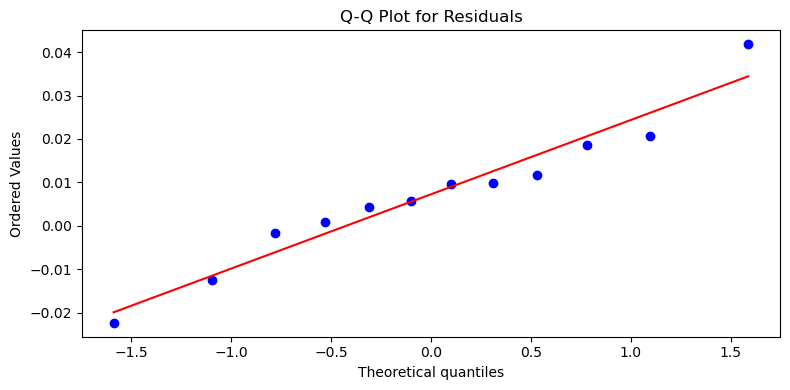

In [6]:
# ---------------------------------------
# Model 1: Backward Stepwise Regression
# ---------------------------------------
def remove_high_vif(X, threshold=10):
    """Remove variables with high VIF value."""
    features = X.copy()

    while True:
        vif_data = pd.DataFrame({
            "Factor": features.columns,
            "VIF": [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
        })
        max_vif = vif_data['VIF'].max()

        if max_vif <= threshold:
            break  # Stop if all remaining VIF values are acceptable

        removed_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'Factor']
        features.drop(columns=removed_feature, inplace=True)
        print(f"Removed '{removed_feature}' (VIF = {max_vif:.2f})")

    print(f"\nFinal VIF Scores:\n{vif_data}")
    return features

# Run Stepwise Regression
bs_initial_model, X_train_initial = stepwise_refinement(X_train, y_train, significance_level=0.05)

X_train_refined = remove_high_vif(X_train_initial)
bs_model, X_train_final = stepwise_refinement(X_train_refined, y_train, significance_level=0.05)

X_test_selected = X_test[X_train_final.columns]
bs_y_pred, bs_r2, bs_rmse, bs_mae = evaluate_model(bs_model, X_test_selected, y_test, add_constant=True)


Optimal alpha: 0.0010
                               
Model Evaluation:                               
R²: 0.9048
RMSE: 0.1298
MAE: 0.0140


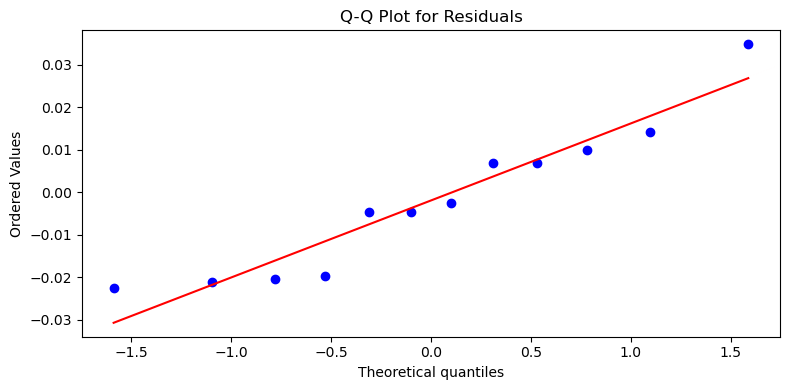

In [7]:
# ------------------------------
# Model 2: Lasso Regression
# ------------------------------
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

lasso = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5).fit(X_train_scaled, y_train)
print(f"\nOptimal alpha: {lasso.alpha_:.4f}")
lasso_y_pred, lasso_r2, lasso_rmse, lasso_mae = evaluate_model(lasso, X_test_scaled, y_test, add_constant=False)


                               
Model Evaluation:                               
R²: 0.8584
RMSE: 0.1433
MAE: 0.0148


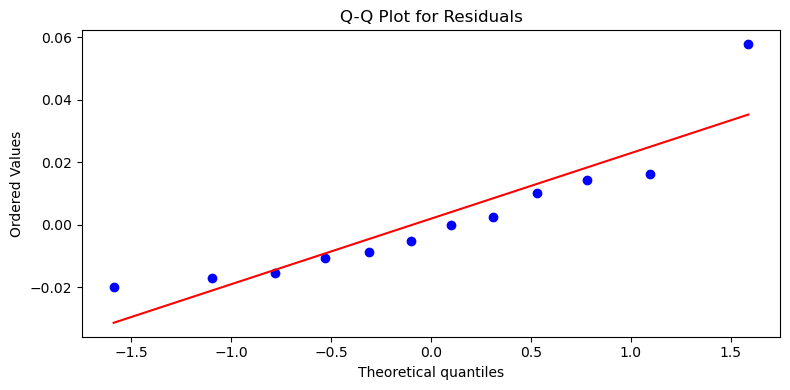

In [8]:
# ------------------------------------
# Model 3: Random Forest Regression
# ------------------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_scaled, y_train)
rf_y_pred, rf_r2, rf_rmse, rf_mae = evaluate_model(rf, X_test_scaled, y_test, add_constant=False)

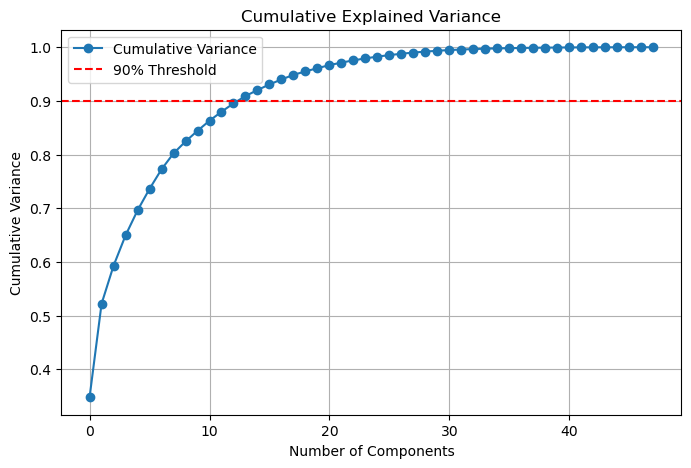

Removing PC6 (p=0.9059)
Removing PC9 (p=0.8193)
Removing PC8 (p=0.7838)
Removing PC11 (p=0.6102)
Removing PC13 (p=0.4022)
Removing PC14 (p=0.3072)
Removing PC7 (p=0.1174)
                               
Model Evaluation:                               
R²: 0.8867
RMSE: 0.1355
MAE: 0.0146


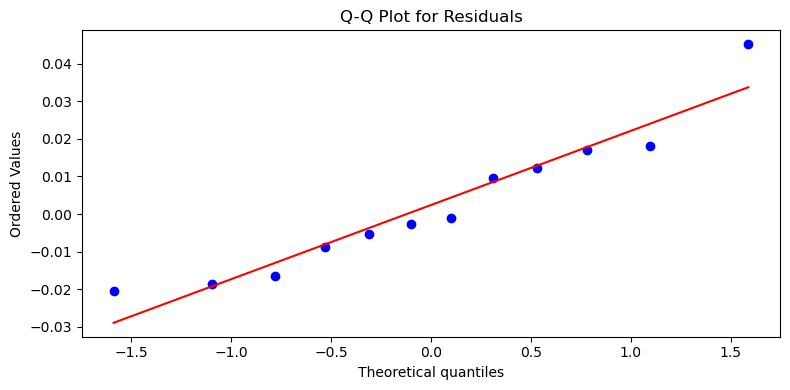

In [9]:
# ------------------------------
# Model 4: PCA Regression
# ------------------------------
def perform_pca(X, variance_threshold=0.9):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit PCA and determine optimal components
    pca = PCA().fit(X_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    # PCA-transformed data
    pca_components = [f'PC{i+1}' for i in range(n_components)]
    X_pca = pd.DataFrame(
        pca.transform(X_scaled)[:, :n_components],
        columns=pca_components,
        index=X.index
    )
    
    # PCA loadings (rotation matrix)
    loadings = pd.DataFrame(
        pca.components_[:n_components].T,
        columns=pca_components,
        index=X.columns
    )

    return scaler, pca, X_pca, n_components, loadings

def plot_pca_variance(pca, variance_threshold=0.9):
    """Plot cumulative explained variance to visualize optimal component selection."""
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-', label='Cumulative Variance')
    plt.axhline(variance_threshold, color='r', linestyle='--', label=f'{variance_threshold * 100:.0f}% Threshold')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pca_loadings(loadings, n_components):
    """Visualize PCA loadings as a heatmap."""
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        loadings,
        cmap='coolwarm',
        center=0,
        annot=True,
        fmt=".2f",
        cbar_kws={'label': 'Loading Weight'},
        linewidths=0.5
    )
    plt.title(f'PCA Component Loadings (First {n_components} Components)', fontsize=14)
    plt.xlabel('Principal Components', fontsize=12)
    plt.ylabel('Original Features', fontsize=12)
    plt.tight_layout()
    plt.show()

# Build PCA model
pca_scaler, pca, X_train_pca, n_components, loadings = perform_pca(X_train)
plot_pca_variance(pca)

# PCA Regression
pca_components = [f'PC{i+1}' for i in range(n_components)]
pca_model, pca_refined = stepwise_refinement(
    pd.DataFrame(X_train_pca, columns=pca_components, index=X_train.index),
    y_train
)

# Evaluate PCA model
X_test_pca = pd.DataFrame(
    pca.transform(pca_scaler.transform(X_test))[:, :n_components],
    columns=pca_components,
    index=X_test.index
)

pca_y_pred, pca_r2, pca_rmse, pca_mae = evaluate_model(pca_model, X_test_pca[pca_refined.columns], y_test, add_constant=True)

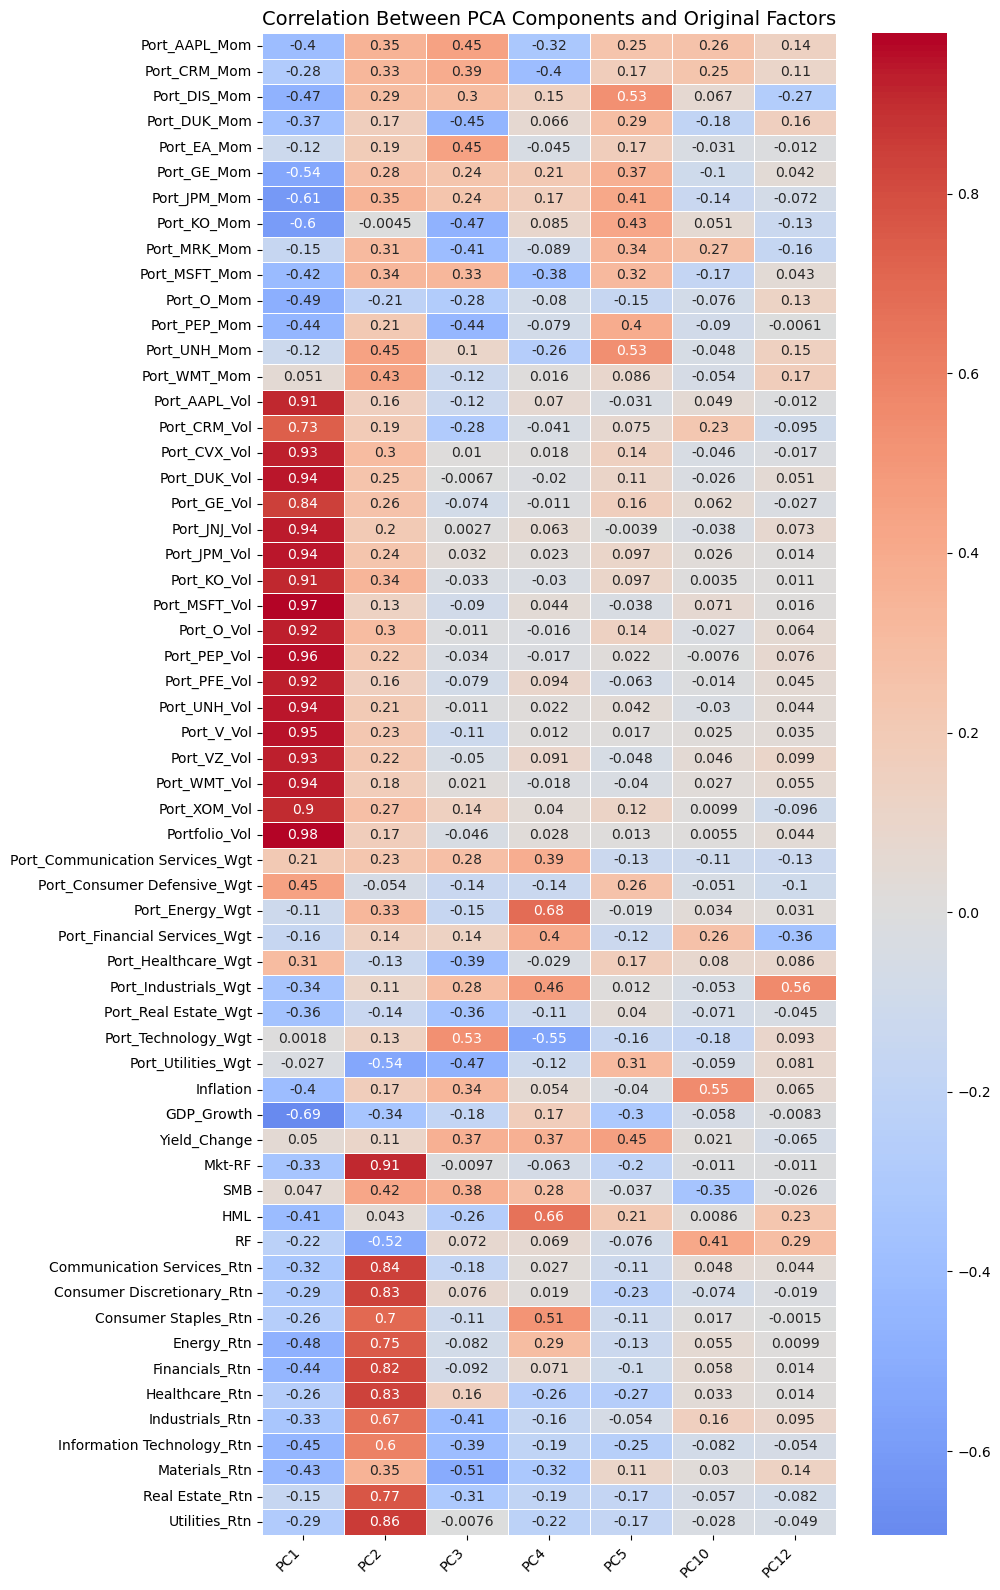

In [10]:
# -------------------------------
# PCA Components Interpretation
# -------------------------------
# Calculate the correlation between each PCA component and all original factors
pca_correlation_matrix = pca_refined.apply(lambda pca_component: X_train.corrwith(pca_component))

# Visualize correlation
plt.figure(figsize=(10, 16))
sns.heatmap(pca_correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Between PCA Components and Original Factors', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Note：

- PCA1: Portfolio volatility, captures common volatility across portfolio assets.
- PCA2: Market movement, reflects systematic market risk.
- PCA3: Technology sector exposure, comparing sector focus (growth vs. defensive).
- PCA4: Value investing, differentiating investing style (value vs. growth).
- PCA5: Interest rate sensitivity
- PCA10: Inflation
- PCA12: Industrials sector idiosyncratic risk, sector-specific variations

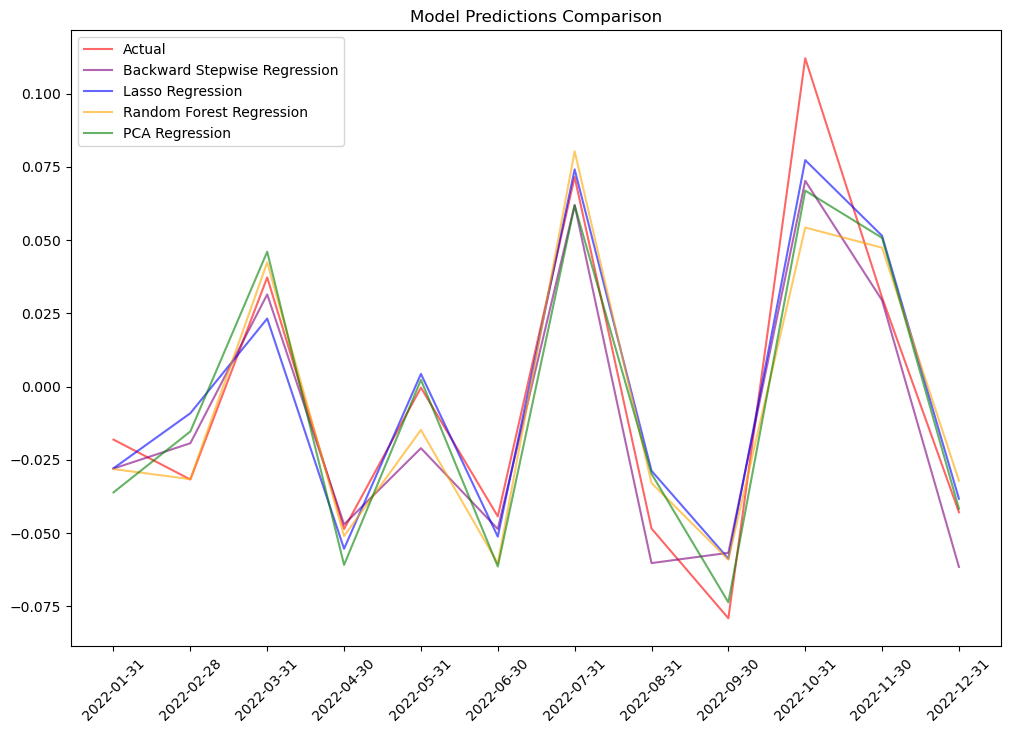


Model Performance Summary:
                       Model       R2     RMSE      MAE
Backward Stepwise Regression 0.900440 0.131237 0.013307
            Lasso Regression 0.904809 0.129773 0.013996
    Random Forest Regression 0.858425 0.143312 0.014842
              PCA Regression 0.886725 0.135540 0.014649


In [11]:
# ------------------------------
# Model Comparison
# ------------------------------
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual', color='red', alpha=0.6)
plt.plot(bs_y_pred, label='Backward Stepwise Regression', color='purple', alpha=0.6)
plt.plot(lasso_y_pred, label='Lasso Regression', color='blue', alpha=0.6)
plt.plot(rf_y_pred, label='Random Forest Regression', color='orange', alpha=0.6)
plt.plot(pca_y_pred, label='PCA Regression', color='green', alpha=0.6)
plt.title('Model Predictions Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Metric Summary
metric_summary_df = pd.DataFrame({
    'Model': ['Backward Stepwise Regression','Lasso Regression', 'Random Forest Regression', 'PCA Regression'],
    'R2': [bs_r2, lasso_r2, rf_r2, pca_r2],
    'RMSE': [bs_rmse, lasso_rmse, rf_rmse, pca_rmse],
    'MAE': [bs_mae, lasso_mae, rf_mae, pca_mae]
})

print("\nModel Performance Summary:")
print(metric_summary_df.to_string(index=False))

Note:

Lasso Regression is the most consistent performer across all three metrics (R2, RMSE, MAE), providing the highest R2 and the lowest RMSE and MAE. This makes it the top model for both explaining variance and minimizing prediction errors.

Backward Stepwise Regression performs similarly to Lasso, with only a slight disadvantage in RMSE and MAE.

PCA Regression performs decently, but it lags slightly behind the first two models in terms of RMSE and MAE.

Random Forest Regression, while potentially useful for capturing nonlinear relationships and interactions, performs the worst across all metrics, especially in terms of RMSE and MAE. This suggests it may be overfitting or that its complexity isn’t contributing to better predictive performance.

##### Part 2: Backtesting

In [12]:
# ------------------------------
# Backtesting Setup
# ------------------------------
def calculate_var(returns, confidence_level=0.95, method='parametric'):
    """Calculate Value-at-Risk using different methods."""
    if method == 'parametric':
        mu = np.mean(returns)
        sigma = np.std(returns)
        return norm.ppf(1 - confidence_level, mu, sigma)
    elif method == 'historical':
        return np.percentile(returns, (1 - confidence_level) * 100)
    else:
        raise ValueError("Invalid method. Choose 'parametric' or 'historical'")

def calculate_violations(actual, var):
    """Calculate VaR violations and ratio."""
    violations = actual < var
    return {
        'ratio': violations.mean(),
        'count': violations.sum(),
        'dates': actual[violations].index
    }

# Initialize backtest predictions storage
backtest_results = {}

# ------------------------------
# Model Predictions
# ------------------------------
X_backtest = backtest_df.drop(columns=['Portfolio_Rtn'])
y_backtest = backtest_df['Portfolio_Rtn']

# Backward Stepwise Regression
backtest_results['Backward Stepwise'] = {
    'predictions': bs_model.predict(sm.add_constant(X_backtest[X_train_final.columns])),
    'color': 'purple'
}

# Lasso Regression
X_backtest_scaled = scaler.transform(X_backtest)
backtest_results['Lasso'] = {
    'predictions': lasso.predict(X_backtest_scaled),
    'color': 'blue'
}

# Random Forest
backtest_results['Random Forest'] = {
    'predictions': rf.predict(X_backtest_scaled),
    'color': 'orange'
}

# PCA Regression
X_backtest_pca = pca.transform(X_backtest_scaled)[:, :n_components]
X_backtest_pca = pd.DataFrame(X_backtest_pca, columns=pca_components, index=X_backtest.index)
X_backtest_pca_const = sm.add_constant(X_backtest_pca[pca_refined.columns])
backtest_results['PCA'] = {
    'predictions': pca_model.predict(X_backtest_pca_const),
    'color': 'green'
}

# Historical Baseline
backtest_results['Historical'] = {
    'var': calculate_var(y_backtest, method='historical'),
    'color': 'red'
}


Value-at-Risk Estimates:
                        VaR
Random Forest     -0.046791
PCA               -0.046240
Lasso             -0.040830
Backward Stepwise -0.036553
Historical        -0.032188

VaR Violation Analysis:
                   Violation Ratio  Violation Count
Backward Stepwise         0.000000                0
Lasso                     0.000000                0
Random Forest             0.000000                0
PCA                       0.000000                0
Historical                0.083333                1


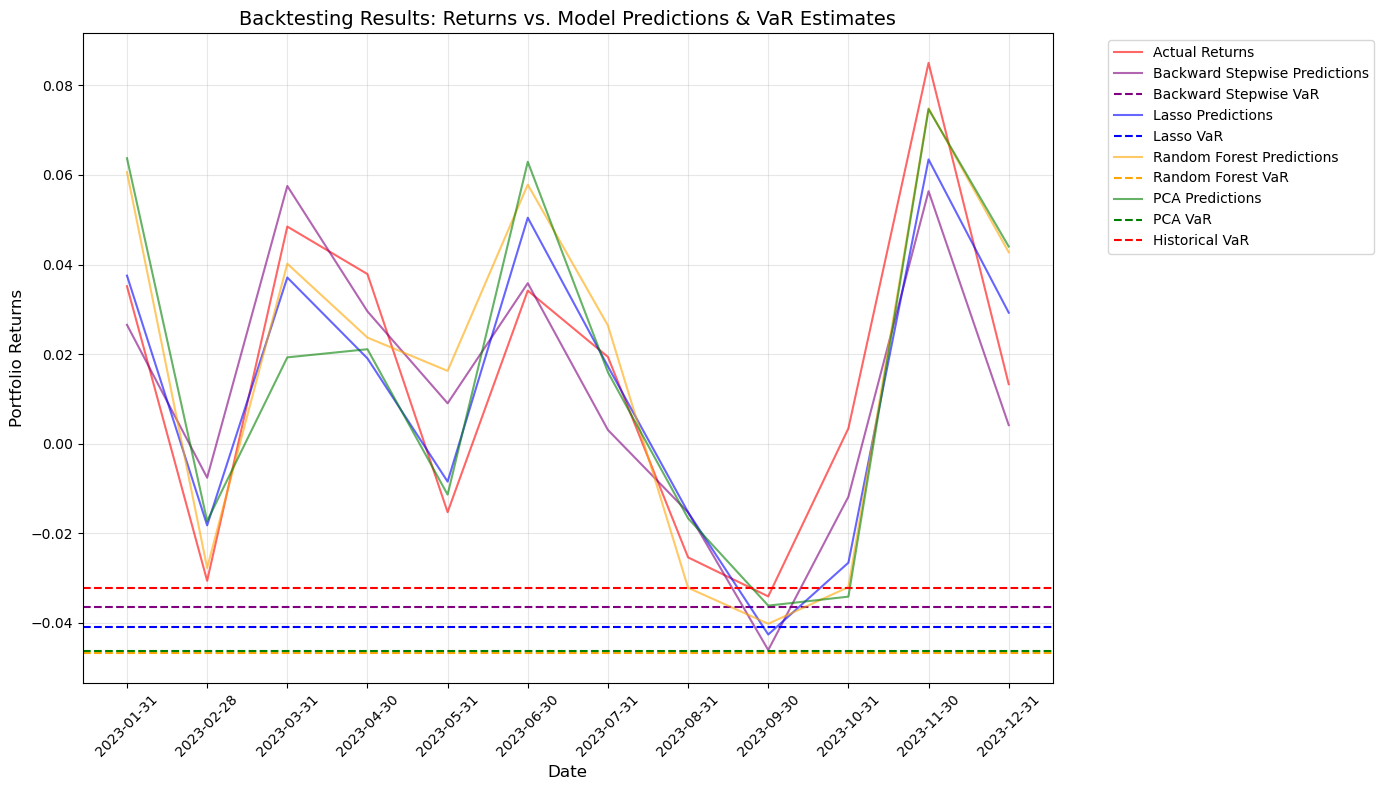

In [13]:
# ------------------------------
# Calculate Risk Metrics
# ------------------------------
var_results = {}
violation_analysis = {}

for model_name, results in backtest_results.items():
    if model_name != 'Historical':
        # Calculate parametric VaR
        var_results[model_name] = calculate_var(results['predictions'])
        
        # Calculate violations
        violation_analysis[model_name] = calculate_violations(
            y_backtest, 
            var_results[model_name]
        )

# Add historical VaR
var_results['Historical'] = backtest_results['Historical']['var']
violation_analysis['Historical'] = calculate_violations(
    y_backtest, 
    var_results['Historical']
)

# ------------------------------
# Risk Reporting
# ------------------------------
print("\nValue-at-Risk Estimates:")
var_df = pd.DataFrame.from_dict(var_results, orient='index', columns=['VaR'])
print(var_df.sort_values('VaR'))

print("\nVaR Violation Analysis:")
violation_df = pd.DataFrame({
    'Violation Ratio': [v['ratio'] for v in violation_analysis.values()],
    'Violation Count': [v['count'] for v in violation_analysis.values()]
}, index=violation_analysis.keys())
print(violation_df)

# ------------------------------
# Visualization
# ------------------------------
plt.figure(figsize=(14, 8))

# Plot actual returns
plt.plot(y_backtest, label='Actual Returns', color='red', alpha=0.6)

# Plot VaR estimates
for model_name, results in backtest_results.items():
    if model_name == 'Historical':
        plt.axhline(y=var_results[model_name], color=results['color'], 
                   linestyle='--', label=f'{model_name} VaR')
    else:
        plt.plot(y_backtest.index, results['predictions'], 
                color=results['color'], alpha=0.6, 
                label=f'{model_name} Predictions')
        plt.axhline(y=var_results[model_name], color=results['color'], 
                   linestyle='--', label=f'{model_name} VaR')

# Formatting
plt.title('Backtesting Results: Returns vs. Model Predictions & VaR Estimates', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Returns', fontsize=12)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Note:

Model Performance:
The model-based VaR estimates (Lasso, Random Forest, PCA, and Backward Stepwise) are more reliable than Historical VaR, as they don’t underpredict risk. However, these models could overestimate risk and may suffer from overfitting, where they capture noise or market anomalies instead of true risk.

Risk Sensitivity:
Historical VaR may underestimate risk, especially during periods of high volatility or extreme events, since it only considers past data. Therefore, it is less reliable compared to the model-based methods, which account for broader data relationships.

Possible Issues:
Model-based approaches might fail to capture extreme events and could overfit the data. Additionally, the testing window might be too small, limiting the models’ ability to predict risks over the long term.

##### Part 3: Risk Decomposition

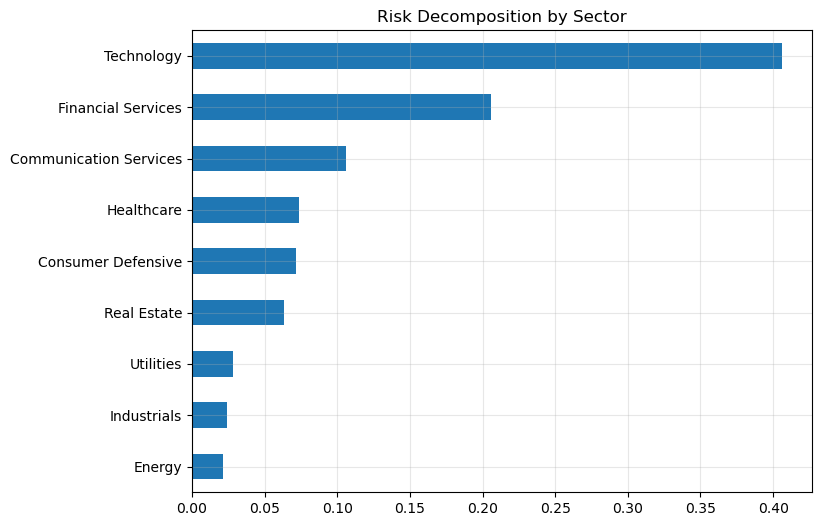

In [14]:
# ------------------------------
# Risk Decomposition by Sector
# ------------------------------

# Extract sector weight and return columns
sector_wgt_cols = [col for col in df_original.columns if '_Wgt' in col]
sector_rtn_cols = [col for col in df_original.columns if 'Port' in col and col.endswith('_Rtn') and 'Portfolio' not in col]

# Select data for backtesting period (2023)
sector_weights = df_original.loc['2023-01-01':, sector_wgt_cols]
sector_weights.columns = [col.replace('Port_', '').replace('_Wgt', '') for col in sector_weights.columns]
port_sector_return = df_original.loc['2023-01-01':, sector_rtn_cols]
port_sector_return.columns = [col.replace('Port_', '').replace('_Rtn', '') for col in port_sector_return.columns]
sectors= sector_weights.columns

# Calculate covariance matrix of sector returns
sector_covariance_matrix = port_sector_return.cov()

# Function to calculate risk contributions
def calculate_risk_contributions(weights, covariance_matrix):
    weights = weights.to_numpy().reshape(-1, 1)  # Ensure column vector

    # Calculate portfolio variance and risk
    portfolio_variance = weights.T @ covariance_matrix @ weights
    portfolio_risk = np.sqrt(portfolio_variance)

    # Calculate risk breakdown by sector
    marginal_risk_contributions = covariance_matrix @ weights
    risk_by_sector = np.multiply(weights.flatten(), marginal_risk_contributions.iloc[:,0]) / portfolio_risk.iloc[0,0]
    risk_contribution = (risk_by_sector / portfolio_risk.iloc[0,0])

    return portfolio_risk, risk_by_sector, risk_contribution

# Dynamic Risk Contributions
dynamic_risk_breakdown = []
for _,sector_weight in sector_weights.iterrows():
    _, risk_by_sector, risk_contribution = calculate_risk_contributions(sector_weight, sector_covariance_matrix)
    dynamic_risk_breakdown.append(risk_contribution.values)

dynamic_risk_df = pd.DataFrame(dynamic_risk_breakdown, index=port_sector_return.index)

# Static Risk Contributions
average_sector_weight = sector_weights.mean()
portfolio_risk_static, static_risk_by_sector, static_risk_contribution = calculate_risk_contributions(average_sector_weight, sector_covariance_matrix)

# Create DataFrame for static risk breakdown
static_risk_breakdown = pd.DataFrame({
    'Risk by Sector': static_risk_by_sector,
    'Risk Contribution (%)': static_risk_contribution
})  # Set the sector names as the index

# Visualize Static Risk Contributions
plt.figure(figsize=(8, 6))
static_risk_breakdown['Risk Contribution (%)'].sort_values(ascending=False).plot.barh()
plt.title('Risk Decomposition by Sector')
plt.grid(alpha=0.3)
plt.gca().invert_yaxis()
plt.show()

In [15]:
# ------------------------------------
# Risk Decomposition by Model Factors
# ------------------------------------

# ------------------------------
# Decomposition Setup
# ------------------------------
def calculate_factor_covariance(X):
    return X.cov()

def linear_risk_decomposition(model, X):
    """ Decompose risk for linear models using factor contributions. """
    try:
        coefficients = pd.Series(model.params.drop('const', errors='ignore')) \
            if isinstance(model, sm.regression.linear_model.RegressionResultsWrapper) \
            else pd.Series(model.coef_, index=X.columns)

        contributions = coefficients @ calculate_factor_covariance(X) * coefficients
        return (contributions / contributions.sum()).sort_values(ascending=False)
    except Exception as e:
        print(f"Error in linear_risk_decomposition: {e}")
        return pd.Series()

def tree_based_risk_decomposition(model, X):
    """ Decompose risk for tree-based models. """
    return pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

def pca_risk_decomposition(pca_model, feature_names, n_components):
    """ Decompose PCA risk through original feature contributions. """
    loadings = pd.DataFrame(pca_model.components_[:n_components].T,
                            columns=[f'PC{i+1}' for i in range(n_components)],
                            index=feature_names)
    explained_variance = pca_model.explained_variance_ratio_[:n_components]
    feature_importance = loadings.abs().multiply(explained_variance, axis=1)
    return feature_importance.div(feature_importance.sum(axis=1), axis=0)

# ------------------------------
# Risk Decomposition Execution
# ------------------------------
portfolio_variance = y_backtest.var()

risk_decompositions = {
    'Backward Stepwise': linear_risk_decomposition(bs_model, X_backtest[X_train_final.columns]),
    'Lasso': linear_risk_decomposition(lasso, pd.DataFrame(X_backtest_scaled, columns=X_train.columns)),
    'Random Forest': tree_based_risk_decomposition(rf, pd.DataFrame(X_backtest_scaled, columns=X_train.columns))
}

pca_feature_contributions = pca_risk_decomposition(pca, X_train.columns, n_components)
pca_component_contrib = linear_risk_decomposition(pca_model, X_backtest_pca[pca_refined.columns])

risk_decompositions['PCA'] = (
    pca_feature_contributions[pca_component_contrib.index]  # Align components
    .mul(pca_component_contrib, axis=1)                     # Multiply contributions
    .sum(axis=1)                                            # Sum across components
    .sort_values(ascending=False)
)

risk_decompositions['PCA'] /= risk_decompositions['PCA'].sum()

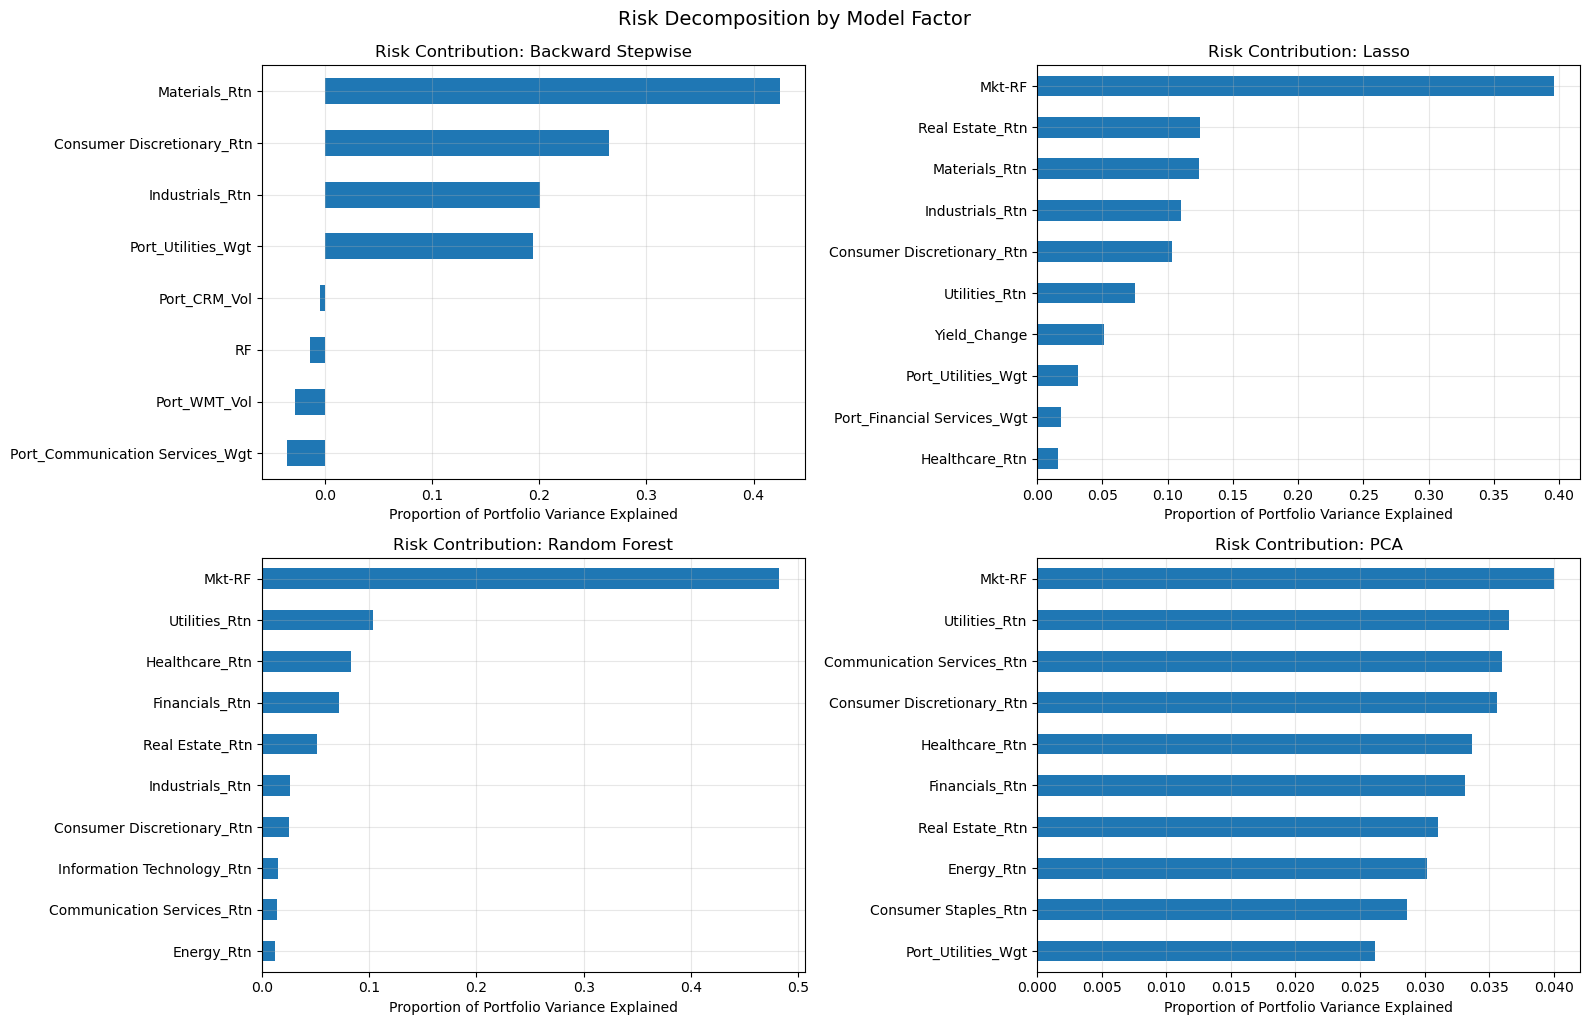

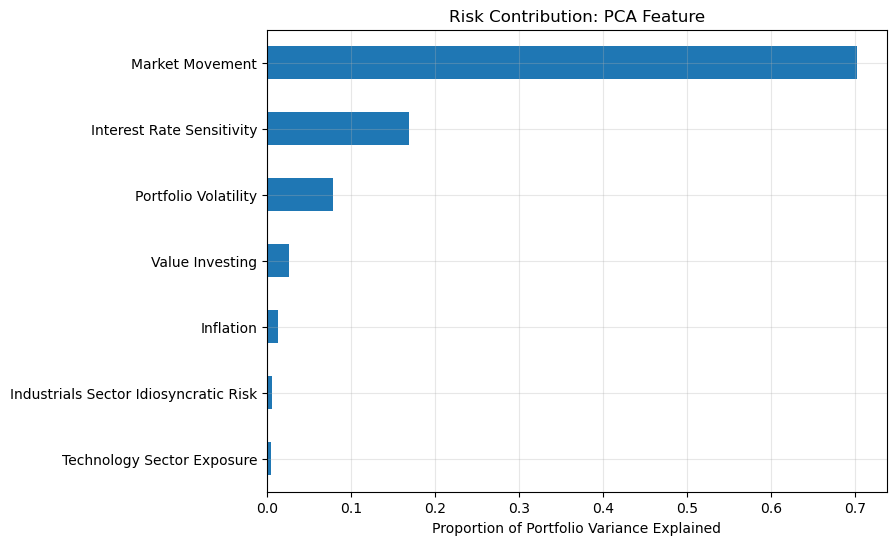


Top Risk Contributors Across Models:


,Backward Stepwise,Lasso,Random Forest,PCA
0,Materials_Rtn,Mkt-RF,Mkt-RF,Mkt-RF
1,Consumer Discretionary_Rtn,Real Estate_Rtn,Utilities_Rtn,Utilities_Rtn
2,Industrials_Rtn,Materials_Rtn,Healthcare_Rtn,Communication Services_Rtn


In [16]:
# ------------------------------
# Visualization
# ------------------------------
plt.figure(figsize=(16, 10))
for i, (model_name, decomposition) in enumerate(risk_decompositions.items(), 1):
    plt.subplot(2, 2, i)
    decomposition.head(10).plot.barh()
    plt.title(f'Risk Contribution: {model_name}')
    plt.xlabel('Proportion of Portfolio Variance Explained')
    plt.grid(alpha=0.3)
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.suptitle('Risk Decomposition by Model Factor', y=1.02, fontsize=14)
plt.show()

# PCA Feature Contribution Visualization

pca_interpretation = {
    'PC1':'Portfolio Volatility',
    'PC2': 'Market Movement',
    'PC3': 'Technology Sector Exposure', 
    'PC4': 'Value Investing',
    'PC5': 'Interest Rate Sensitivity',
    'PC10': 'Inflation',
    'PC12': 'Industrials Sector Idiosyncratic Risk'
}

plt.figure(figsize=(8, 6))
pca_component_contrib.plot.barh()
tick_labels = [pca_interpretation.get(comp, comp) for comp in pca_component_contrib.index]

plt.yticks(range(len(pca_component_contrib)), tick_labels)
plt.title('Risk Contribution: PCA Feature')
plt.xlabel('Proportion of Portfolio Variance Explained')
plt.grid(alpha=0.3)
plt.gca().invert_yaxis()
plt.show()

# ------------------------------
# Summary
# ------------------------------
risk_df = pd.concat(risk_decompositions, axis=1).fillna(0)
print("\nTop Risk Contributors Across Models:")
risk_df.apply(lambda s: s.nlargest(3).index.tolist(), axis=0)

Note:
From the risk decomposition by model factors, the majority of the portfolio’s risk is driven by market movements, which is a positive sign, suggesting that the portfolio is well diversified. Interest rate risk also plays an important role, but its contribution to the overall portfolio risk is relatively smaller compared to market movements.

##### Part 4: Stress Testing

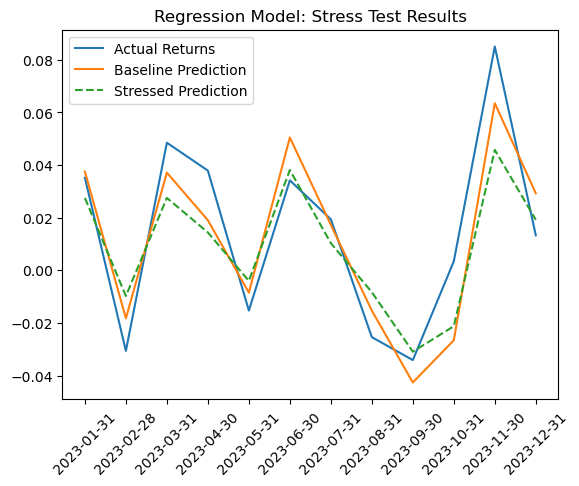


Mean Returns:
Mean Actual Returns: 0.0143
Mean Baseline Prediction: 0.0119
Mean Stressed Prediction: 0.0090


In [17]:
# Stress test scenario setup
X_stressed = X_backtest.copy()
X_stressed['Mkt-RF'] *= 0.7   # Simulate 30% decrease in market return
rtn_columns = [col for col in X_stressed.columns if 'Rtn' in col]
X_stressed[rtn_columns] *= 0.7

# ------------------------
# LASSO Regression Model
# ------------------------

# Lasso Regression
X_stressed_scaled = scaler.transform(X_stressed)
y_pred_stressed_lasso = lasso.predict(X_stressed_scaled)
y_pred_backtest_lasso = list(backtest_results['Lasso'].values())[0]

# Plot results
plt.plot(y_backtest, label='Actual Returns')
plt.plot(y_pred_backtest_lasso, label='Baseline Prediction')
plt.plot(y_pred_stressed_lasso, label='Stressed Prediction', linestyle='--')
plt.xticks(rotation=45)
plt.legend()
plt.title('Regression Model: Stress Test Results')
plt.show()

result_df = pd.DataFrame({
    'Actual Returns': y_backtest,
    'Baseline Prediction': y_pred_backtest_lasso,
    'Stressed Prediction': y_pred_stressed_lasso
})

mean_actual = y_backtest.mean()
mean_baseline = y_pred_backtest_lasso.mean()
mean_stressed = y_pred_stressed_lasso.mean()

print(f"\nMean Returns:")
print(f"Mean Actual Returns: {mean_actual:.4f}")
print(f"Mean Baseline Prediction: {mean_baseline:.4f}")
print(f"Mean Stressed Prediction: {mean_stressed:.4f}")